## Import Library

In [1]:
import dgl
from dgl.data import DGLDataset
import os
import pandas as pd
import numpy as np
import torch
import itertools
import numpy as np
import scipy.sparse as sp
import dgl.nn as dglnn
import torch.nn as nn
import torch.nn.functional as F
import dgl.function as fn
from dgl.nn.pytorch import conv as dgl_conv
from startup_data_set import COMP4222Dataset_hetero
from PredictorClasses import *
from CustomMetrics import *
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
device = torch.device('cpu')

### Hypermeters

In [2]:
val_ratio = 0.1
test_ratio = 0.1

n_hidden = 64
n_layers = 3
feat_drop = 0.5
att_drop = 0.5
activation = F.elu
negative_slope = 0.2
heads = [2, 2,2]
residual = False

## Load Dataset

In [3]:
graph = COMP4222Dataset_hetero()[0]
graph = dgl.to_homogeneous(graph,ndata=['feat'],edata=['feat'])
graph

Graph(num_nodes=25446, num_edges=45621,
      ndata_schemes={'feat': Scheme(shape=(221,), dtype=torch.float64), '_ID': Scheme(shape=(), dtype=torch.int64), '_TYPE': Scheme(shape=(), dtype=torch.int64)}
      edata_schemes={'feat': Scheme(shape=(23,), dtype=torch.float64), '_ID': Scheme(shape=(), dtype=torch.int64), '_TYPE': Scheme(shape=(), dtype=torch.int64)})

In [4]:
in_feats = graph.ndata['feat'].shape[1]
in_feats

221

## Generate Postitve Graph and Negative Graph with Spliting

In [6]:
from CustomUtilities import generate_neg_graph, generate_pos_graph
train_g, train_pos_g, val_pos_g, test_pos_g = \
    generate_pos_graph(graph, val_ratio, test_ratio)

train_g

Graph(num_nodes=25446, num_edges=61943,
      ndata_schemes={'feat': Scheme(shape=(221,), dtype=torch.float64), '_ID': Scheme(shape=(), dtype=torch.int64), '_TYPE': Scheme(shape=(), dtype=torch.int64)}
      edata_schemes={'feat': Scheme(shape=(23,), dtype=torch.float64), '_ID': Scheme(shape=(), dtype=torch.int64), '_TYPE': Scheme(shape=(), dtype=torch.int64)})

In [7]:
train_neg_g, val_neg_g, test_neg_g = \
    generate_neg_graph(graph, val_ratio, test_ratio)

train_neg_g

Graph(num_nodes=25446, num_edges=36497,
      ndata_schemes={}
      edata_schemes={})

## Model Training

### Model Setup

In [8]:
class GATModel(nn.Module):
    def __init__(self, in_feat, n_hidden, heads, n_layers, activation, feat_drop, att_drop, negative_slope, residual):
        super(GATModel, self).__init__()
        self.layers = nn.ModuleList()
        # parameter list: input feature size, hidden layer size, multi_head attention,
        self.layers.append(dgl_conv.GATConv(in_feat, n_hidden, heads[0], feat_drop, att_drop, negative_slope, False, activation))
        for i in range(1, n_layers):
            self.layers.append(dgl_conv.GATConv(n_hidden*heads[i-1], n_hidden, heads[i], 
                                                feat_drop, att_drop, negative_slope, residual, activation))
        self.layers.append(dgl_conv.GATConv(n_hidden*heads[-1], n_hidden, heads[-1], feat_drop, att_drop,
                                            negative_slope, residual, activation))
        
    def forward(self, g, features):
        h = features.float()
        for i in range(len(self.layers)):
            h = self.layers[i](g, h).flatten(1).float()
        h = self.layers[-1](g, h).mean(1).float()
        return h

In [9]:
gat_model = GATModel(
    in_feats, 
    n_hidden, 
    heads, 
    n_layers, 
    activation, 
    feat_drop, 
    att_drop, 
    negative_slope, 
    residual)

pred = DotPredictor()

### Training Loop

In [10]:
import itertools

train_loss, val_loss = [], []
train_AUC, val_AUC = [], []
stop = 0

optimizer = torch.optim.Adam(itertools.chain(gat_model.parameters(), pred.parameters()), lr=0.01)

for e in range(500):
    # forward
    h = gat_model(train_g, train_g.ndata['feat'])
    pos_score = pred(train_pos_g, h)
    neg_score = pred(train_neg_g, h)
    loss = compute_loss(pos_score, neg_score)
    train_loss.append(loss.item())
    train_AUC.append(compute_auc(pos_score, neg_score))

    # backward
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # validation
    v_pos_score = pred(val_pos_g, h)
    v_neg_score = pred(val_neg_g, h)
    v_loss = compute_loss(v_pos_score, v_neg_score)
    val_loss.append(v_loss.item())
    val_AUC.append(compute_auc(v_pos_score, v_neg_score))

    #verbose
    if e % 5 == 0:
        print('Epoch: {} \t\t\t Train loss: {} \t\t\t Val loss: {}'.format(e, loss, v_loss))


    # early stopping
    if len(val_loss) > 2 and val_loss[-1] > val_loss[-2]:
        stop += 1
    if stop >= 30:
        print("Early Stopped at Epoch {}".format(e))
        break


Epoch: 0 			 Train loss: 8.43037223815918 			 Val loss: 7.9535908699035645
Epoch: 5 			 Train loss: 1.0991369485855103 			 Val loss: 1.40202796459198
Epoch: 10 			 Train loss: 1.031347393989563 			 Val loss: 1.3385210037231445
Epoch: 15 			 Train loss: 0.9637793302536011 			 Val loss: 1.230247139930725
Epoch: 20 			 Train loss: 0.8768953084945679 			 Val loss: 1.0324325561523438
Epoch: 25 			 Train loss: 0.7994742393493652 			 Val loss: 0.9590030908584595
Epoch: 30 			 Train loss: 0.7691921591758728 			 Val loss: 0.9148252010345459
Epoch: 35 			 Train loss: 0.746171772480011 			 Val loss: 0.8931131362915039
Epoch: 40 			 Train loss: 0.7094055414199829 			 Val loss: 0.8452767133712769
Epoch: 45 			 Train loss: 0.698174238204956 			 Val loss: 0.8099184632301331
Epoch: 50 			 Train loss: 0.6856049299240112 			 Val loss: 0.7892143726348877
Epoch: 55 			 Train loss: 0.6779872179031372 			 Val loss: 0.7920156121253967
Epoch: 60 			 Train loss: 0.6674022078514099 			 Val loss: 0.7932276725769

In [11]:
# testing AUC
with torch.no_grad():
    pos_score = pred(test_pos_g, h)
    neg_score = pred(test_neg_g, h)
    print('AUC:', compute_auc(pos_score, neg_score))

AUC: 0.5159550254172576


### Result Plotting

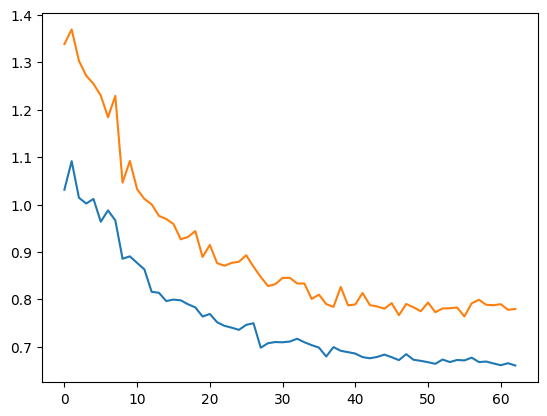

In [12]:

plt.plot(train_loss[10:])
plt.plot(val_loss[10:])

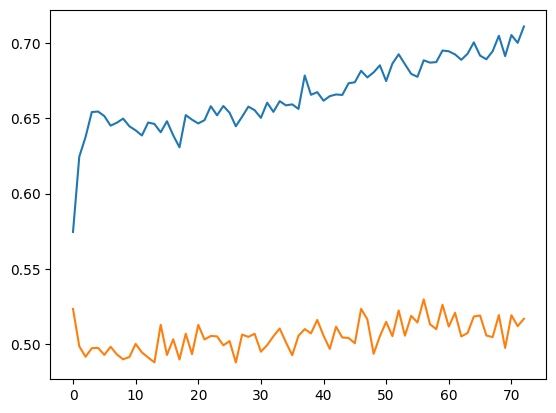

In [13]:
plt.plot(train_AUC)
plt.plot(val_AUC)